In [105]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
# import seaborn as sns
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import glob as glob
# import arrow
import matplotlib
matplotlib.style.use('ggplot')

In [106]:
weekly_df = pd.read_csv("dengue-cases.csv",index_col=False)
weekly_df = weekly_df.set_index('date')
weekly_df = weekly_df.iloc[209:]
weekly_df.index = pd.DatetimeIndex(weekly_df.index)

In [107]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

In [108]:
train_mask = (weekly_df.index > "2006") & (weekly_df.index <= "2011")
train = weekly_df[train_mask].cases
test_mask = (weekly_df.index > "2011")
test = weekly_df[test_mask].cases

$$\theta\,(w_{i}\cdot x_{i}) = \frac{1}{1\,+\,e^{-\sum_{i=0}^{n} w_{i} x_{i}}}$$

$$\log cases = \log (w_{n}) + \log\,\theta(w\cdot x) \,+\, ...$$

In [86]:
from scipy.special import expit
from scipy.optimize import fmin, minimize

def get_alphas(lag,train):
    
    BETAS_SET = lag + 1
    ALL_WS = BETAS_SET + 1
    
    def guess(w,x):
        def theta(w,x):
            pad_x = np.concatenate(([1],np.array(x)))
            score = np.dot(w[:-1],pad_x)
            return expit(score)

        return np.log(theta(w,x)+ 1e-5) + w[-1] 
    
    def cost(w):
        ret = 0
        for i in range(len(train)-ALL_WS):
            real_case = np.log(train[i+ALL_WS])
            predicted_case = guess(w,train[i:i+lag])
            ret += (real_case - predicted_case)**2
        return ret/float(len(train))
    
    starter = np.log(3000.)#np.log(7500.)
    arr = np.array([0.]*BETAS_SET)
    arr = np.append(arr,starter)
    w = minimize(cost,arr).x
    return w


# doesn't work
################################################

def n_week_ahead(w,array_x,weeks_ahead):
    theta = 0
    arr = np.array(array_x)
    for i in range(weeks_ahead):
        # exponentiate the log case back
        theta = np.exp(guess(w,arr))
        arr = np.append(arr[1:],theta)
    return theta

def make_n_prediction_lines(w,nweeks,nweek_to_predict,test):
    for i in nweek_to_predict:
        N = nweeks + (i - 1)
        tmp = []
        for j in range(len(test)-N):
            initial_arr = test[j:j+nweeks]
            tmp.append(n_week_ahead(w,initial_arr,i)) 

        title = 'Dengue Prediction %d lags: %d weeks ahead'%(nweeks,i)
        make_line(NWEEKS+i,test,tmp,title,"# week starting 2009","cases")

In [82]:
# LAG = 26
# nweek_to_predict = [1,2,4]

# w_26 = get_alphas(LAG,train)

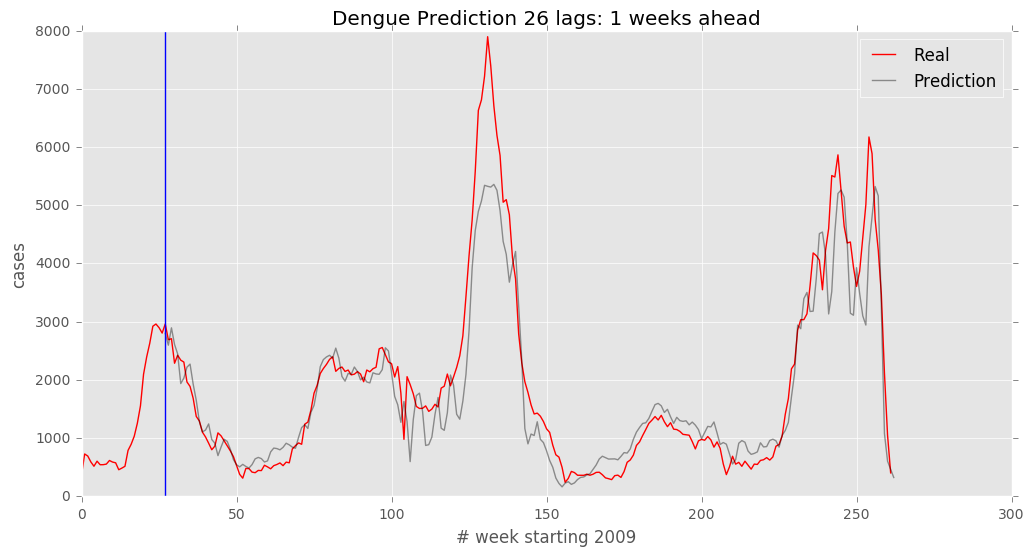

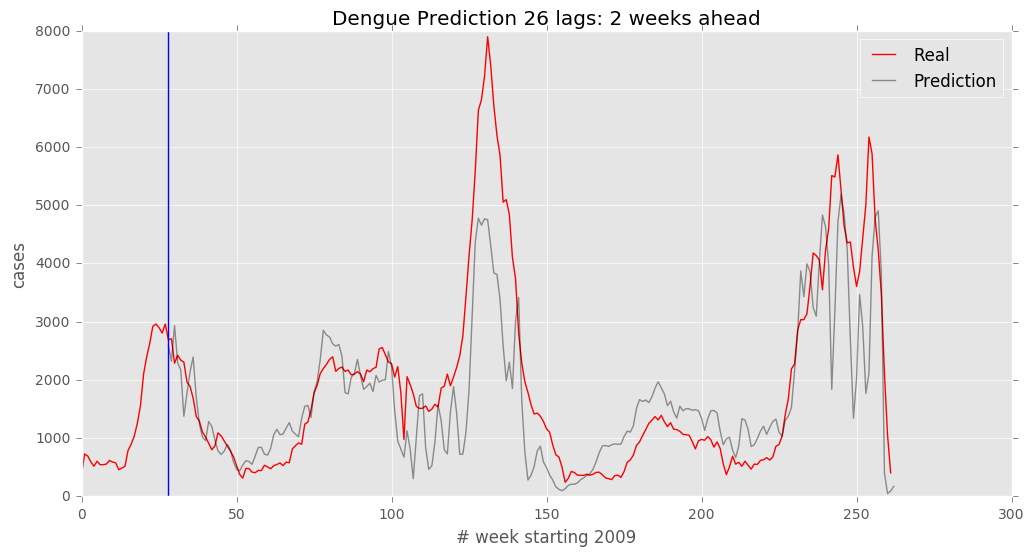

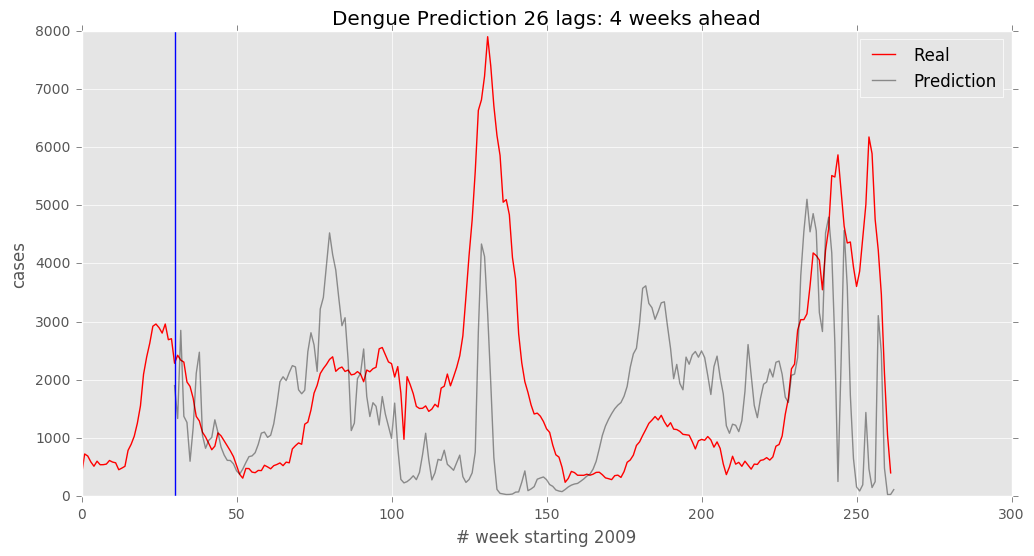

In [94]:
# make_n_prediction_lines(w_26,LAG,nweek_to_predict,test)

In [88]:
LAG = 52
nweek_to_predict = [1,2,4]

w_52 = get_alphas(LAG,train)

In [96]:
# make_n_prediction_lines(w_52,52,nweek_to_predict,test)

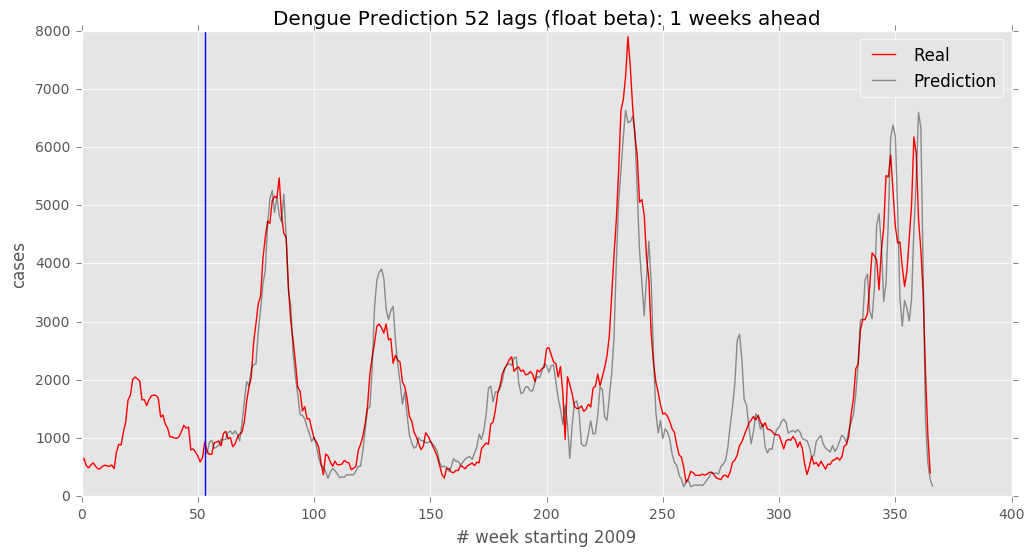

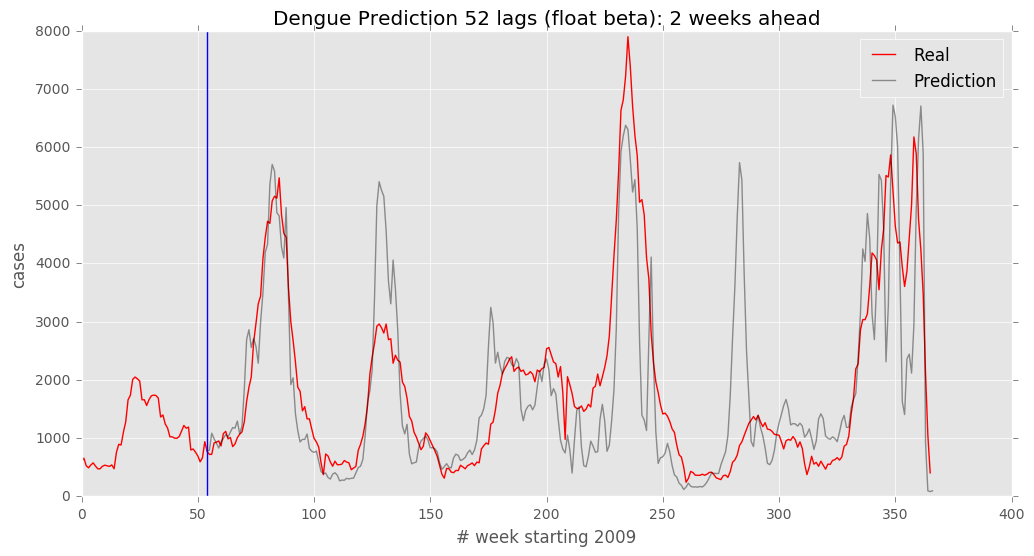

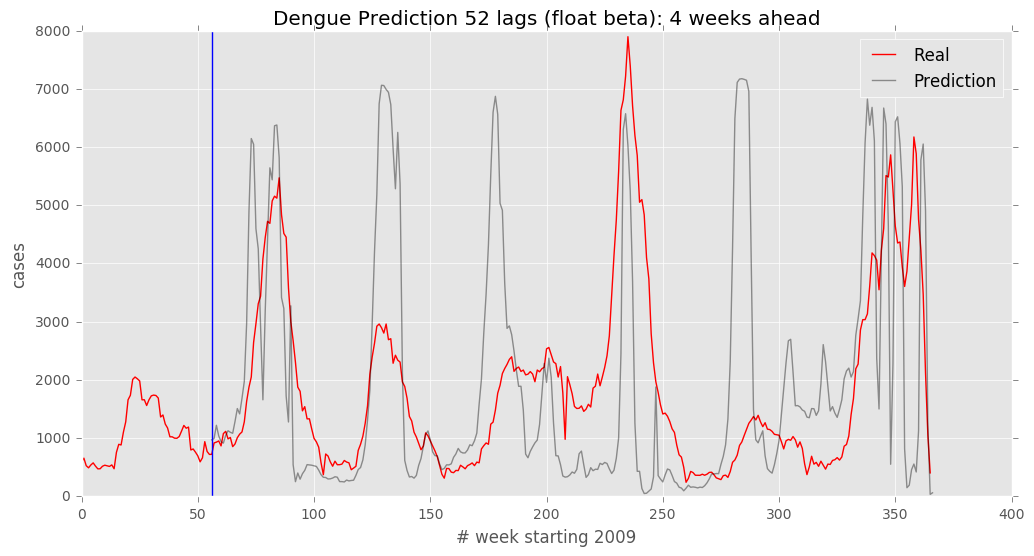

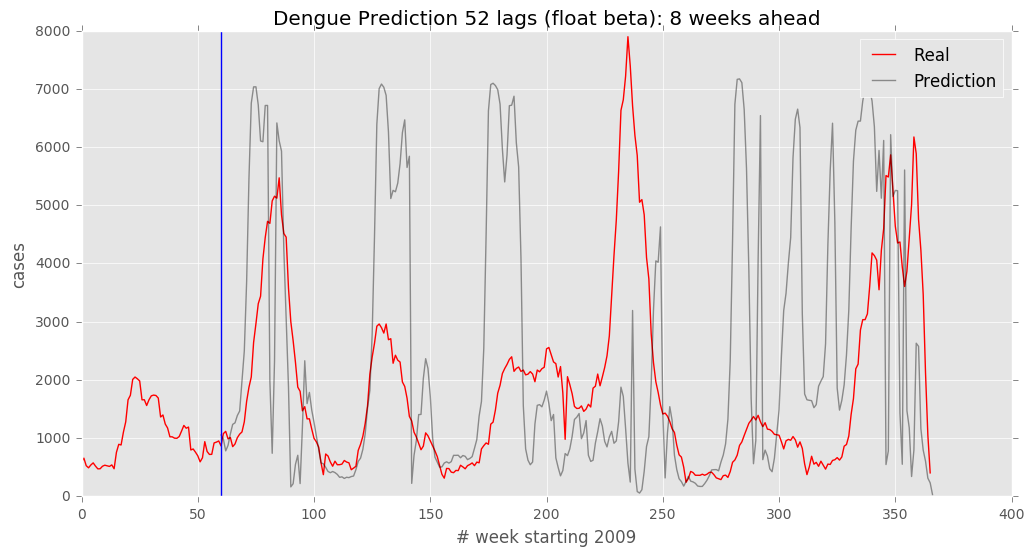

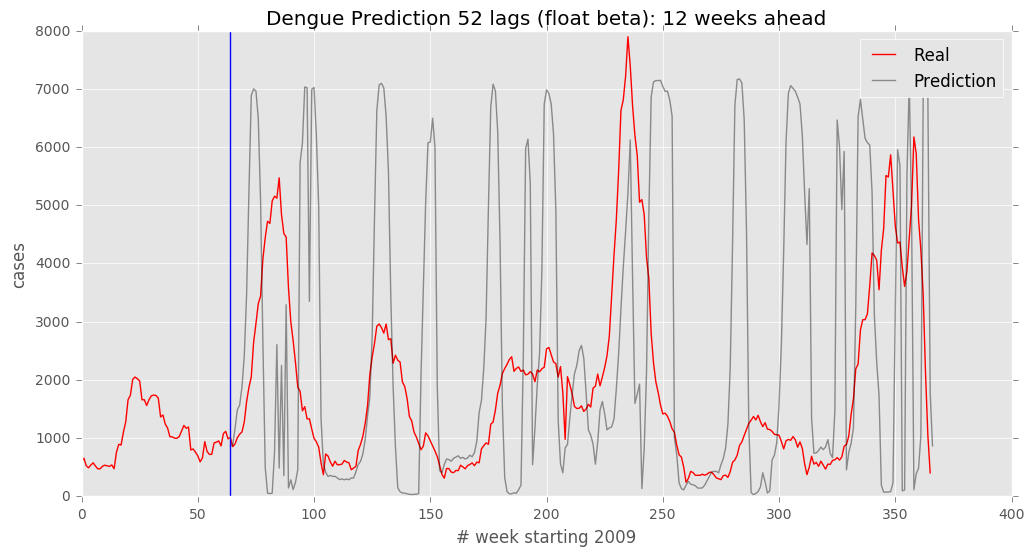

In [102]:
def n_week_ahead(array_x,weeks_ahead):
    
    theta = 0
    arr = np.array(array_x)
    for i in range(weeks_ahead):
        # exponentiate the log case back
        theta = np.exp(guess(w_52,arr))
        arr = np.append(arr[1:],theta)
    return theta


NWEEKS = 52

nweek_to_predict = [1,2,4,8,12]

test = weekly_df.cases[104:]
for i in nweek_to_predict:
    N = NWEEKS + (i - 1)
    tmp = []
    for j in range(len(test)-N):
        initial_arr = test[j:j+NWEEKS]
        tmp.append(n_week_ahead(initial_arr,i)) 
    
    title = 'Dengue Prediction 52 lags (float beta): %d weeks ahead'%i
    make_line(NWEEKS+i,test,tmp,title,"# week starting 2009","cases")

In [ ]:
# use week number as feature for seasonality